In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Ignore certain warnings
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [4]:
# Upload all NYC benchmarking csvs
df_2010 = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84_2011__Data_for_Calendar_Year_2010__20250210.csv", low_memory=False)
df_2011 = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84_2012__Data_for_Calendar_Year_2011__20250210.csv", low_memory=False)
df_2012 = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84_2013__Data_for_Calendar_Year_2012__20250203.csv", low_memory=False)
df_2013 = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84_2014__Data_for_Calendar_Year_2013__20250210.csv", low_memory=False)
df_2014 = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84_2015__Data_for_Calendar_Year_2014__20250210.csv", low_memory=False)
df_2015 = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84_2016__Data_for_Calendar_Year_2015__20250203.csv", low_memory=False)
df_2016 = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016__20250210.csv", low_memory=False)
df_2017 = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84_2018__Data_for_Calendar_Year_2017__20250210.csv", low_memory=False)
df_2018 = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84_2019__Data_for_Calendar_Year_2018__20250210.csv", low_memory=False)
df_2019 = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84_2020__Data_for_Calendar_Year_2019__20250210.csv", low_memory=False)
df_2020 = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84_2021__Data_for_Calendar_Year_2020__20250210.csv", low_memory=False)
df_2021 = pd.read_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84_2022__Data_for_Calendar_Year_2021__20250210.csv", low_memory=False)
df_2022 = pd.read_csv("NYC_Building_Energy_and_Water_Data_Disclosure_for_Local_Law_84__2022-Present__20250128.csv", low_memory=False)

In [5]:
# Read key matching csv
df_column_keys = pd.read_csv("keys_initial_nyc.csv")

In [6]:
# Limit rows in dfs to be ones specified in keys csv
for year in range(2014, 2023):
    year_str = str(year)
    
    # Retrieve the DataFrame dynamically
    df = globals()[f'df_{year}']
    
    expected_columns = df_column_keys[year_str]
    
    missing_columns = [col for col in expected_columns if col not in df.columns]
    
    # Add missing columns with NaN values
    for col in missing_columns:
        df[col] = np.nan  

    # Create the simplified DataFrame with the correct columns
    globals()[f'df_{year}_simp'] = df[expected_columns]


In [7]:
# Rename columns to be standardized based on spreadsheet key
for year in range(2014,2023):
    globals()[f'df_{year}_simp'].columns = df_column_keys['2022']

In [8]:
# Concat into one dataframe
dfs_to_concat = [globals()[f'df_{year}_simp'] for year in range(2014, 2023)]

df_combined_raw = pd.concat(dfs_to_concat, ignore_index=True)

In [9]:
# Get statistics on raw dataframe
print(len(df_combined_raw))
print(df_combined_raw['Property ID'].nunique())

256662
52978


In [10]:
# Drop rows without WN Source EUI data
df_combined_raw['Weather Normalized Source EUI (kBtu/ft²)'] = df_combined_raw['Weather Normalized Source EUI (kBtu/ft²)'].replace('Not Available',np.nan).astype(float)
df_combined = df_combined_raw[df_combined_raw['Weather Normalized Source EUI (kBtu/ft²)'].notna()]

In [11]:
# Apply log to WN Source EUI
df_combined['ln_source_eui'] = np.log(df_combined['Weather Normalized Source EUI (kBtu/ft²)'])

C:\Users\etien\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\etien\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
# Make year column
df_combined['year'] = df_combined['Year Ending'].str[-4:].astype(int)

In [13]:
# Clean columns
df_combined['ENERGY STAR Score'] = df_combined['ENERGY STAR Score'].replace('Not Available',np.nan).astype(float)

In [14]:
# Drop duplicate entries in a year
df_combined = df_combined.sort_values(by='Report Submission Date',ascending=False).drop_duplicates(subset=['Property ID','year'])

In [15]:
#standardize french property names to english
french_to_english = {
    'Résidence/dortoir': 'Residence Hall/Dormitory',
    'Collège/Université': 'College/University',
    'Bureau': 'Office',
    'Immeuble à logements multiples': 'Multifamily Housing',
    'Autre - Éducation': 'Other - Education',
    'Lieu de culte': 'Worship Facility',
    'Autre': 'Other',
    'Hôtel': 'Hotel',
    'Patinoire/piste de curling': 'Ice/Curling Rink',
    'Autre - Divertissement/Rassemblement public': 'Other - Entertainment/Public Assembly',
    'Usine de fabrication/industrie': 'Manufacturing/Industrial Plant',
    'Résidence pour personnes âgées': 'Senior Care Community',
    'Propriété à usage mixte': 'Mixed Use Property',
    'Entrepôt non réfrigéré': 'Non-Refrigerated Warehouse'
}

# Apply the mapping
df_combined['Primary Property Type - Self Selected'] = df_combined['Primary Property Type - Self Selected'].replace(french_to_english)

In [16]:
# Remove the 1% and 99% outliers

lower_eui_value = df_combined['ln_source_eui'].quantile(.01)
upper_eui_value = df_combined['ln_source_eui'].quantile(.99)

df_combined['ln_source_eui'] = df_combined['ln_source_eui'].where(
    (df_combined['ln_source_eui'] > lower_eui_value) & 
    (df_combined['ln_source_eui'] < upper_eui_value)
)

In [17]:
# Remove entries that are 3 standard deviations outside the group mean (likely meter errors)

# Find mean and std for every Property ID
df_lnsource_means = df_combined.groupby('Property ID')['ln_source_eui'].agg(['mean','std'])
df_combined = df_combined.merge(df_lnsource_means, on='Property ID')

# Keep only entries within 3 standard deviations
df_combined = df_combined[
    (df_combined['ln_source_eui'] >= df_combined['mean'] - 3 * df_combined['std']) &
    (df_combined['ln_source_eui'] <= df_combined['mean'] + 3 * df_combined['std'])
]

<Axes: xlabel='ln_source_eui', ylabel='Count'>

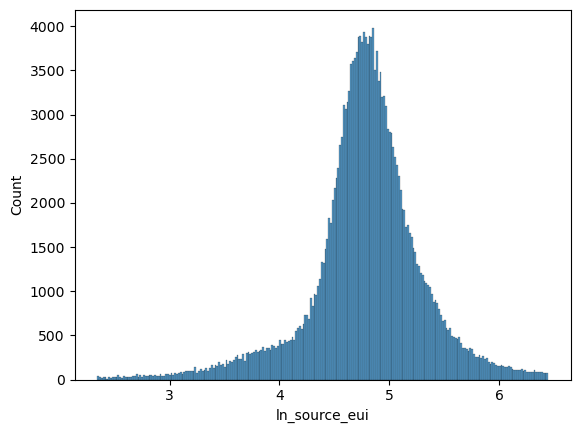

In [18]:
sns.histplot(df_combined['ln_source_eui'])

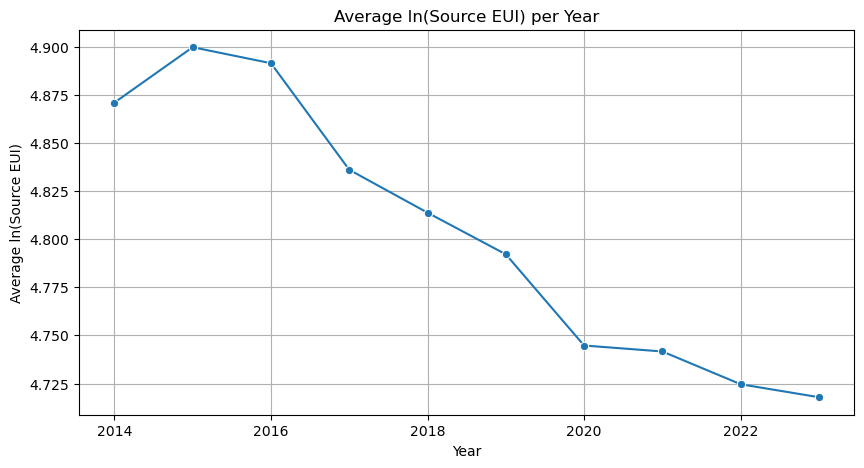

In [21]:
# Compute average EUI per year
df_avg_eui = df_combined.groupby('year')['ln_source_eui'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_avg_eui, x='year', y='ln_source_eui', marker='o')
plt.xlabel("Year")
plt.ylabel("Average ln(Source EUI)")
plt.title("Average ln(Source EUI) per Year")
plt.grid(True)
plt.show()

In [22]:
# Convert numerical string columns to floats
df_combined['Property GFA - Self-Reported (ft²)'] = df_combined['Property GFA - Self-Reported (ft²)'].astype(float)

In [1]:
# for i in df_combined.columns:
#     print(f"'{i}',")

In [24]:
# List of energy columns to be used
energy_cols = [
    'Natural Gas Use (kBtu)',
    'District Steam Use (kBtu)',
    'District Hot Water Use (kBtu)',
    'District Chilled Water Use (kBtu)'
]

# List of columns for 'All Other Fuel Use (kBtu)'
other_fuel_cols = [
    'Propane Use (kBtu)',
    'Kerosene Use (kBtu)',
    'Fuel Oil #1 Use (kBtu)',
    'Fuel Oil #2 Use (kBtu)',
    'Fuel Oil #4 Use (kBtu)',
    'Fuel Oil #5 & 6 Use (kBtu)',
    'Diesel #2 Use (kBtu)'
]

# List of columns for 'Electricity Use (kBtu)'
electricity_cols = [
    'Electricity Use - Grid Purchase (kBtu)',
    'Electricity Use - Grid Purchase and Generated from Onsite Renewable Systems (kBtu)',
    'Electricity Use – Generated from Onsite Renewable Systems and Used Onsite (kWh)',
    'Electricity Use – Generated from Onsite Renewable Systems (kWh)'
]

# Convert all relevant columns to float and fill NaNs with 0
df_combined[energy_cols] = df_combined[energy_cols].replace(['Not Available','Insufficient access'],np.nan).astype(float).fillna(0)
df_combined[other_fuel_cols] = df_combined[other_fuel_cols].replace(['Not Available','Insufficient access'],np.nan).astype(float).fillna(0)
df_combined[electricity_cols] = df_combined[electricity_cols].replace(['Not Available','Insufficient access'],np.nan).astype(float).fillna(0)

# Compute additional energy categories
df_combined['All Other Fuel Use (kBtu)'] = df_combined[other_fuel_cols].sum(axis=1)
df_combined['Electricity Use (kBtu)'] = df_combined[electricity_cols].sum(axis=1)

# Update the energy_cols list to include these new columns
energy_cols.extend(['All Other Fuel Use (kBtu)', 'Electricity Use (kBtu)'])

# Compute total energy use
df_combined['total_energy_use'] = df_combined[energy_cols].sum(axis=1)

# Compute energy ratios and clean columns
for col in energy_cols:
    df_combined[f'{col}_ratio'] = df_combined[col] / df_combined['total_energy_use']

    df_combined[f'{col}_ratio'] = df_combined[f'{col}_ratio'].clip(lower=0, upper=1)

C:\Users\etien\AppData\Local\Temp\ipykernel_21572\2905558720.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined[other_fuel_cols] = df_combined[other_fuel_cols].replace(['Not Available','Insufficient access'],np.nan).astype(float).fillna(0)


In [25]:
# Find number of years a building reported data
years_reported = df_combined.groupby('Property ID')['year'].count()

df_combined['years_reported'] = df_combined['Property ID'].map(years_reported)

In [26]:
#Add features from PLUTO database
df_pluto = pd.read_csv("pluto_24v4_1.csv", low_memory=False)

#use first BBL from set
df_combined['bbl'] = pd.to_numeric(
    df_combined['NYC Borough, Block and Lot (BBL)'].str.replace('-', '').str[:10],
    errors='coerce'
)

# Set 'bbl' as index and keep only desired features
df_pluto_floors = df_pluto.set_index('bbl')[['numfloors', 'landuse', 'bldgarea', 'assessland', 'assesstot', 'builtfar','yearalter1','yearalter2','unitsres','unitstotal','lotfront','lotdepth','bldgfront','bldgdepth']]

# Map 'bbl' to features to add to df_combined
df_combined = df_combined.join(df_pluto_floors, on='bbl')

# Merge yearalter tables to be the most recent column
df_combined['yearalter'] = df_combined['yearalter2'].fillna(df_combined['yearalter1'])


In [27]:
# Calculate square footage of building

df_combined['sqft'] = df_combined['Property GFA - Calculated (Buildings and Parking) (ft²)'].replace('Not Available',np.nan).fillna(df_combined['Property GFA - Self-Reported (ft²)']).astype(float)

In [63]:
# Find age of buildings
df_combined['Year Built'] = df_combined['Year Built'].replace('Not Available',np.nan).astype(float)

# Since only 7 entries without years built, drop them
df_combined = df_combined[df_combined['Year Built'].notna()]

# Calculate building age
df_combined['age'] = df_combined['year'] - df_combined['Year Built']

# Clean values
df_combined['age'] = df_combined['age'].clip(lower=0, upper=200)

In [65]:
# Create building ages bins
bins = list(range(0, 101, 20)) + [float('inf')]

labels = ['0-19', '20-39', '40-59', '60-79', '80-99', '100+']

df_combined['age_bin'] = pd.cut(df_combined['age'], bins=bins, labels=labels, right=False)

In [67]:
# Create building sqft bins
bins = [0, 50000, 100000, 150000, 200000, 300000, float('inf')]

labels = ['0-49k', '50k-99k', '100k-149k', '150k-199k', '200k-299k', '300k+']

df_combined['sqft_bin'] = pd.cut(df_combined['sqft'], bins=bins, labels=labels, right=False)


In [69]:
df_combined['assesstot_persqft'] = df_combined['assesstot'] / df_combined['sqft']

In [70]:
# Export csv
df_combined.to_csv('nyc_cleaned.csv')